In [153]:
# import face_recognition
from deepface import DeepFace
from deepface.detectors import FaceDetector
import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

from retinaface.model import retinaface_model
from retinaface.commons import preprocess, postprocess

In [164]:
import os
import pandas as pd
dirt = '../../../../mnt/DATA/datasets/soccernet/france_ligue-1/2015-2016/2015-09-26 - 18-30 Nantes 1 - 4 Paris SG'
os.listdir(dirt)
pd.read_json(dirt+'/Labels-v2.json')['annotations'][5]

{'gameTime': '1 - 05:35',
 'label': 'Ball out of play',
 'position': '335266',
 'team': 'not applicable',
 'visibility': 'not shown'}

In [140]:
def postprocess_function(net_out, im_info, im_scale, threshold=0.9):
    nms_threshold = 0.4;
    decay4 = 0.5

    _feat_stride_fpn = [32, 16, 8]

    _anchors_fpn = {
        'stride32': np.array([[-248., -248., 263., 263.], [-120., -120., 135., 135.]], dtype=np.float32),
        'stride16': np.array([[-56., -56., 71., 71.], [-24., -24., 39., 39.]], dtype=np.float32),
        'stride8': np.array([[-8., -8., 23., 23.], [0., 0., 15., 15.]], dtype=np.float32)
    }

    _num_anchors = {'stride32': 2, 'stride16': 2, 'stride8': 2}

    proposals_list = []
    scores_list = []
    landmarks_list = []

    # net_out = [elt.numpy() for elt in net_out]
    sym_idx = 0

    for _idx, s in enumerate(_feat_stride_fpn):
        _key = 'stride%s' % s

        scores = net_out[sym_idx]
        scores = scores[:, :, :, _num_anchors['stride%s' % s]:]

        bbox_deltas = net_out[sym_idx + 1]
        height, width = bbox_deltas.shape[1], bbox_deltas.shape[2]

        A = _num_anchors['stride%s' % s]
        K = height * width
        anchors_fpn = _anchors_fpn['stride%s' % s]
        anchors = postprocess.anchors_plane(height, width, s, anchors_fpn)
        anchors = anchors.reshape((K * A, 4))
        scores = scores.reshape((-1, 1))

        bbox_stds = [1.0, 1.0, 1.0, 1.0]
        bbox_deltas = bbox_deltas
        bbox_pred_len = bbox_deltas.shape[3] // A
        bbox_deltas = bbox_deltas.reshape((-1, bbox_pred_len))
        bbox_deltas[:, 0::4] = bbox_deltas[:, 0::4] * bbox_stds[0]
        bbox_deltas[:, 1::4] = bbox_deltas[:, 1::4] * bbox_stds[1]
        bbox_deltas[:, 2::4] = bbox_deltas[:, 2::4] * bbox_stds[2]
        bbox_deltas[:, 3::4] = bbox_deltas[:, 3::4] * bbox_stds[3]
        proposals = postprocess.bbox_pred(anchors, bbox_deltas)

        proposals = postprocess.clip_boxes(proposals, im_info[:2])

        if s == 4 and decay4 < 1.0:
            scores *= decay4

        scores_ravel = scores.ravel()
        order = np.where(scores_ravel >= threshold)[0]
        proposals = proposals[order, :]
        scores = scores[order]

        proposals[:, 0:4] /= im_scale
        proposals_list.append(proposals)
        scores_list.append(scores)

        landmark_deltas = net_out[sym_idx + 2]
        landmark_pred_len = landmark_deltas.shape[3] // A
        landmark_deltas = landmark_deltas.reshape((-1, 5, landmark_pred_len // 5))
        landmarks = postprocess.landmark_pred(anchors, landmark_deltas)
        landmarks = landmarks[order, :]

        landmarks[:, :, 0:2] /= im_scale
        landmarks_list.append(landmarks)
        sym_idx += 3

    proposals = np.vstack(proposals_list)
    if proposals.shape[0] == 0:
        landmarks = np.zeros((0, 5, 2))
        return {}  # np.zeros((0, 5)), landmarks # CHANGE JOSEP
    scores = np.vstack(scores_list)
    scores_ravel = scores.ravel()
    order = scores_ravel.argsort()[::-1]

    proposals = proposals[order, :]
    scores = scores[order]
    landmarks = np.vstack(landmarks_list)
    landmarks = landmarks[order].astype(np.float32, copy=False)

    pre_det = np.hstack((proposals[:, 0:4], scores)).astype(np.float32, copy=False)

    # nms = cpu_nms_wrapper(nms_threshold)
    # keep = nms(pre_det)
    keep = postprocess.cpu_nms(pre_det, nms_threshold)

    det = np.hstack((pre_det, proposals[:, 4:]))
    det = det[keep, :]
    landmarks = landmarks[keep]

    resp = {}
    for idx, face in enumerate(det):
        label = 'face_' + str(idx + 1)
        resp[label] = {}
        resp[label]["score"] = face[4]

        resp[label]["facial_area"] = list(face[0:4].astype(int))

        resp[label]["landmarks"] = {}
        resp[label]["landmarks"]["right_eye"] = list(landmarks[idx][0])
        resp[label]["landmarks"]["left_eye"] = list(landmarks[idx][1])
        resp[label]["landmarks"]["nose"] = list(landmarks[idx][2])
        resp[label]["landmarks"]["mouth_right"] = list(landmarks[idx][3])
        resp[label]["landmarks"]["mouth_left"] = list(landmarks[idx][4])

    return resp

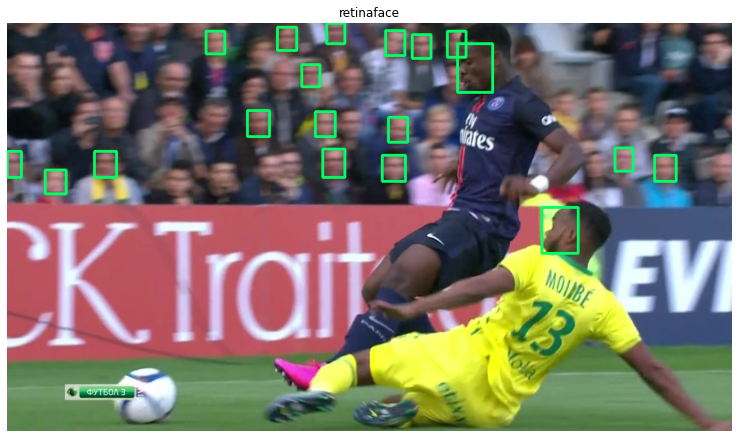

In [223]:
# cares a frames que ens donarien PROBLEMES
image1 = '../../../../mnt/DATA/datasets/soccernet/france_ligue-1/2015-2016/2015-09-26 - 18-30 Nantes 1 - 4 Paris SG/1_HQ/frames/01795.jpg'
image2 = '../../../../mnt/DATA/datasets/soccernet/france_ligue-1/2015-2016/2015-09-26 - 18-30 Nantes 1 - 4 Paris SG/1_HQ/frames/02745.jpg'

# frames bons, demostrar RETINAFACE BO (comparar amb altres detectors: OpenCV detecta escut, ssd no detecta, mtcnn mateix)
image3 = '../../../../mnt/DATA/datasets/soccernet/france_ligue-1/2015-2016/2015-09-26 - 18-30 Nantes 1 - 4 Paris SG/1_HQ/frames/02930.jpg'
# opencv no detecta, mtcnn detecta lo mateix
image4 = '../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-07 - 22-45 Napoli 1 - 3 Real Madrid/1_HQ/frames/15369.jpg'
# bona foto, celebracio --> opencv detecta menys, ssd no detecta, mtcnn detecta moltes, pero una mica menys que retina
image5 = '../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-07 - 22-45 Napoli 1 - 3 Real Madrid/1_HQ/frames/11696.jpg'

image = cv2.imread(image2)
model = retinaface_model.build_model()
processed_image, info, scale = preprocess.preprocess_image(image, True)
outputs = model(processed_image)
outputs = [elt.numpy() for elt in outputs]
faces = postprocess_function(outputs, info, scale)

faces_list = [faces[f'face_{i}']['facial_area'] for i in range(1, len(faces)+1)]

RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if len(faces_list)>0:
    imagec2 = RGB_img.copy()
    for face in faces_list:
        #cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
        cv2.rectangle(imagec2, (face[0], face[1]), (face[2],face[3]), (0,255,100), 3) 
    fig = plt.figure(figsize=(15,7.5)) 
    plt.title('retinaface')
    plt.axis('off')
    plt.imshow(imagec2)
    plt.show() 


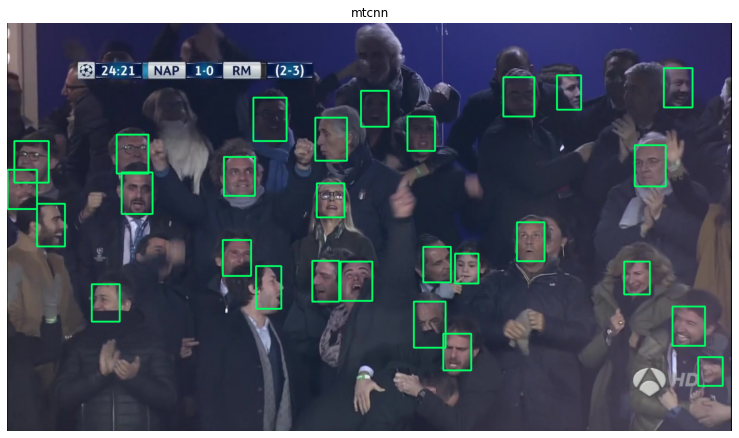

In [222]:
# using face_locations
'''face_locations = face_recognition.face_locations(image)

print(len(face_locations))
if len(face_locations)>0:
    imagec1 = image.copy()
    for face in face_locations:
        cv2.rectangle(imagec1, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
    fig = plt.figure(figsize=(15,7.5)) 
    plt.imshow(imagec1)
    plt.show() 
'''

# using deepface
detector_name = 'mtcnn'
detector = FaceDetector.build_model(detector_name)
face_locations_deep = FaceDetector.detect_faces(detector, detector_name, image)

RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if len(face_locations_deep)>0:
    imagec2 = RGB_img.copy()
    for box, face in face_locations_deep:
        #cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
        cv2.rectangle(imagec2, (face[0], face[1]), (face[0]+face[2],face[1]+face[3]), (0,255,100), 3) 
    fig = plt.figure(figsize=(15,7.5)) 
    plt.title(detector_name)
    plt.axis('off')
    plt.imshow(imagec2)
    plt.show() 



In [233]:
face_locations = FaceDetector.detect_faces(detector, detector_name, image)
face_locations[0][1]

[1680, 351, 135, 170]

In [239]:
import numpy as np
array = np.array(face_locations)
faces = []
for arr in array:
    print(arr[1])
    faces.append(arr[1])
    
faces

[1680, 351, 135, 170]
[563, 223, 148, 189]
[1618, 616, 134, 168]
[1080, 896, 128, 182]
[981, 429, 130, 167]
[1090, 227, 130, 176]
[1627, 40, 146, 209]
[847, 134, 172, 240]
[182, 558, 111, 142]
[1303, 476, 161, 206]
[561, 545, 123, 187]
[1683, 913, 149, 165]
[267, 14, 133, 189]
[1833, 597, 85, 177]
[1552, 31, 110, 171]
[1320, 643, 128, 172]


[[1680, 351, 135, 170],
 [563, 223, 148, 189],
 [1618, 616, 134, 168],
 [1080, 896, 128, 182],
 [981, 429, 130, 167],
 [1090, 227, 130, 176],
 [1627, 40, 146, 209],
 [847, 134, 172, 240],
 [182, 558, 111, 142],
 [1303, 476, 161, 206],
 [561, 545, 123, 187],
 [1683, 913, 149, 165],
 [267, 14, 133, 189],
 [1833, 597, 85, 177],
 [1552, 31, 110, 171],
 [1320, 643, 128, 172]]